## Model
Nesse notebook inciarei a modelagem para prever movimentação das catracas e farei comentários à respeito das conclusões do modelo.

In [8]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importando csv do notebook `02_dataviz`

In [0]:
df = pd.read_csv('/content/drive/My Drive/Raizen/df_2.csv.gz')

In [10]:
df.shape

(1364033, 32)

## Modelling

Abaixo realizei a previsão do fluxo de entrada e de saída.

Realizei o treino para os dados de 2011 a 2015 com cross validation com 3 pastas e teste nos dados de 2016.

A métrica apropriada escolhida foi o rmsle (root mean squared logarithmic error) visto que ela penaliza mais estimativas subestimadas que a superestimadas, ou seja, ela penaliza mais predições que estimam baixo fluxo de pessoas do que alto tráfego.

No entanto, caso a predição contenha valores negativos, só o rmse será informado.

Em um primeiro momento, avaliei alguns algoritmos de regressão: lasso, ridge, regressão linear, knn, decision tree e random forest; escolher o melhor modelo para realizar a tunagem de hiperparâmetro apropriada.


In [0]:
def fit_sub(x_train, y_train, x_test, y_test, mdl):

  y_cv = cross_val_predict(mdl, x_train, y_train, cv=3)
  mdl.fit(x_train, y_train)
  pred_y = mdl.predict(x_test)

  try:
    print(f'cv train rmsle: \t{np.sqrt(mean_squared_log_error(y_cv, y_train))}')
    print(f'test rmsle: \t\t{np.sqrt(mean_squared_log_error(pred_y, y_test))}')
    print(f'cv train rmse: \t\t{np.sqrt(mean_squared_error(y_cv, y_train))}')
    print(f'test rmse: \t\t{np.sqrt(mean_squared_error(pred_y, y_test))}')
  except:
    print(f'cv train rmse: \t{np.sqrt(mean_squared_error(y_cv, y_train))}')
    print(f'test rmse: \t{np.sqrt(mean_squared_error(pred_y, y_test))}')

  return pred_y


def fit_and_test_reg(df, mdl=None, rs=False, dropcol=['station', 'linename', 'month', 'weekday', 'timespan', 'weekend']):
  df = df.drop(dropcol, axis=1)

  x_train = df.query('year < 2016').drop(['entries_diff', 'exits_diff', 'year'], axis=1)
  y_train_ent = df.query('year < 2016')['entries_diff']
  y_train_exi = df.query('year < 2016')['exits_diff']

  x_test = df.query('year == 2016').drop(['entries_diff', 'exits_diff', 'year'], axis=1)
  y_test_ent = df.query('year == 2016')['entries_diff']
  y_test_exi = df.query('year == 2016')['exits_diff']

  if rs:
    print('\ntraining for entries:')
    pred_entries = fit_sub_rs(x_train, y_train_ent, x_test, y_test_ent, mdl)
    print('\ntraining for exits:')
    pred_exits = fit_sub_rs(x_train, y_train_exi, x_test, y_test_exi, mdl)

  else:
    print('\ntraining for entries:')
    pred_entries = fit_sub(x_train, y_train_ent, x_test, y_test_ent, mdl)
    print('\ntraining for exits:')
    pred_exits = fit_sub(x_train, y_train_exi, x_test, y_test_exi, mdl)

  return pred_entries, pred_exits

In [12]:
models = {    
    'lr': LinearRegression(),
    'lasso': Lasso(alpha=.1),
    'ridge': Ridge(),
    'knn': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=7)
}

for name, clf in models.items():    
    print('\n=========================\n')      
    print('fitting model: ' + name )
    mdl = models[name]
    
    pred_entries, pred_exits = fit_and_test_reg(df, mdl=mdl)    



fitting model: lr

training for entries:
cv train rmse: 	10419.179551396077
test rmse: 	9026.179079030906

training for exits:
cv train rmse: 	7895.289020910576
test rmse: 	6446.209191116788


fitting model: lasso

training for entries:
cv train rmse: 	10423.468599953527
test rmse: 	9026.214897983999

training for exits:
cv train rmse: 	7907.3747877287815
test rmse: 	6446.217658800565


fitting model: ridge

training for entries:
cv train rmse: 	10420.09903191935
test rmse: 	9026.18490492551

training for exits:
cv train rmse: 	7897.867033436792
test rmse: 	6446.212021616671


fitting model: knn

training for entries:
cv train rmsle: 	1.3421246007974093
test rmsle: 		1.2017153834549494
cv train rmse: 		11134.815914935534
test rmse: 		8099.054784472555

training for exits:
cv train rmsle: 	1.5752950737365161
test rmsle: 		1.1906201131211274
cv train rmse: 		8515.03981945073
test rmse: 		5805.985749410105


fitting model: Decision Tree

training for entries:
cv train rmsle: 	1.23092506

## Hyperparameter tuning - Random Forest

A regressão linear, lasso e ridge predizeram valores negativos e por isso não são apropriados para a previsão de movimentação de pessoas.

Dentre os demais modelos, a decision tree obteve o menor rmsle para entrada `0,954` e saída `0,989`. Além oferecer menor tempo de treinamento.

No entanto, usarei o Random Forest para tunar hiperparâmetros com random search para avaliar se podemos ter ganhos em relação ao rmsle.

In [0]:
def fit_sub_rs(x_train, y_train, x_test, y_test, mdl):

  param_distributions  = {
                        'max_depth': [5, 6, 7, 8, 9, 10],
                        'min_samples_split': [2, 3, 4]}

  mdl_rs = RandomizedSearchCV(mdl, param_distributions, n_iter = 100, cv = 3,
                              verbose=1, random_state=42,
                              scoring='neg_mean_squared_log_error')

  mdl_rs.fit(x_train, y_train)
  print('random search best params:')
  print(mdl_rs.best_params_)
  pred_y = mdl_rs.best_estimator_.predict(x_test)

  print(f'test rmsle: \t\t{np.sqrt(mean_squared_log_error(pred_y, y_test))}')

  return pred_y

In [26]:
pred_entries, pred_exits = fit_and_test_reg(df, mdl=RandomForestRegressor(), rs=True)


training for entries:
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.2min finished


random search best params:
{'min_samples_split': 4, 'max_depth': 10}
test rmsle: 		0.97094679284263

training for exits:
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.1min finished


random search best params:
{'min_samples_split': 3, 'max_depth': 8}
test rmsle: 		1.0811436939940569


A Random Forest obteve rmsle na entrada e saída de `0.971` e `1,081`.

Como os erros são maiores que na Decision Tree, usarei a decision para avaliar o modelo final. 

In [45]:
pred_entries, pred_exits = fit_and_test_reg(df, mdl=DecisionTreeRegressor(), rs=False)


training for entries:
cv train rmsle: 	1.2278797683079552
test rmsle: 		0.953835512770561
cv train rmse: 		10662.084404876494
test rmse: 		7144.458458275424

training for exits:
cv train rmsle: 	1.3808684304417116
test rmsle: 		0.9893397189678219
cv train rmse: 		8125.645323417539
test rmse: 		5040.275036159905


## Conclusão

Por fim, avaliarei o tráfego predito com o real no ano de 2016 para cada mês, dia da semana, horário do dia, estação e linha.

In [0]:
df_final = df.query('year == 2016').copy()
df_final.loc[:, 'pred_entries'] = pred_entries
df_final.loc[:, 'pred_exits'] = pred_exits

In [0]:
df_final.drop(['year', 'div_BMT', 'div_IND', 'div_IRT',
               'div_PTH_RIT_SRT', 'turnstile', 'weekend', 'hour_afternoon',
               'hour_dawn', 'hour_dusk', 'hour_evening', 'hour_midday', 'hour_morning',
               'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
               'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace=True)

In [0]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_final['weekday'] = pd.Categorical(df_final['weekday'], categories=weekdays, ordered = True)

timespan = ['dawn', 'morning', 'midday', 'afternoon', 'evening', 'dusk']
df_final['timespan'] = pd.Categorical(df_final['timespan'], categories=timespan, ordered = True)

df_final.rename(columns={'entries_diff': 'true_entries',
                   'exits_diff': 'true_exits'}, inplace=True)

In [0]:
def plot_results_time(df, group):        
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    df_group = df.groupby(group)['true_entries', 'pred_entries', 'true_exits', 'pred_exits'].sum()
    df_group.plot(marker='o', y=['true_entries', 'pred_entries'], ax=ax[0], title='Entries')
    df_group.plot(marker='o', y=['true_exits', 'pred_exits'], ax=ax[1], title='Exits')    

def plot_results(df, y, ax=None, title=''):        
    df.plot(marker='o', y=y, ax=ax, title=title, rot=15)
    
def plot_results_location(df, group):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    
    df_group = df.groupby(group)['true_entries', 'pred_entries', 'true_exits', 'pred_exits'].sum()
    df_group['entries_delta'] = abs(df_group['true_entries'] - df_group['pred_entries'])
    df_group['exits_delta'] = abs(df_group['true_exits'] - df_group['pred_exits'])
    
    df_top_ent = df_group.sort_values('entries_delta').head(10)
    plot_results(df_top_ent, ['true_entries', 'pred_entries'], ax=ax[0][0], title='Top entries')
    
    df_last_ent = df_group.sort_values('entries_delta').tail(10)
    plot_results(df_last_ent, ['true_entries', 'pred_entries'], ax=ax[1][0], title='Last entries')
    
    df_top_exi = df_group.sort_values('exits_delta').head(10)
    plot_results(df_top_exi, ['true_exits', 'pred_exits'], ax=ax[0][1], title='Top exits')
    
    df_last_exi = df_group.sort_values('exits_delta').tail(10)
    plot_results(df_last_exi, ['true_exits', 'pred_exits'], ax=ax[1][1], title='Last exits')

Abaixo temos que o modelo se adequou melhor às movimentações de saída do que de entrada, tendo subestimado o tráfego da saída em outubro.

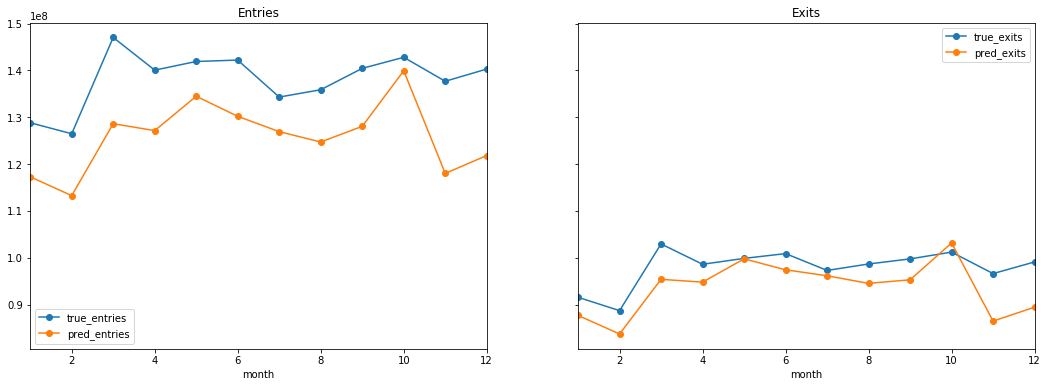

In [50]:
plot_results_time(df_final, group='month')

Como não utilizamos a feature dia de semana e sim, se o dia da semana é um final de semana ou não, o modelo previu que o tráfego seria praticamente constante para todos os dias. Talvez pudéssemos ter usado os dias da semana para avaliar ganhos caso quiséssemos ter melhor previsão nessa granularidade.

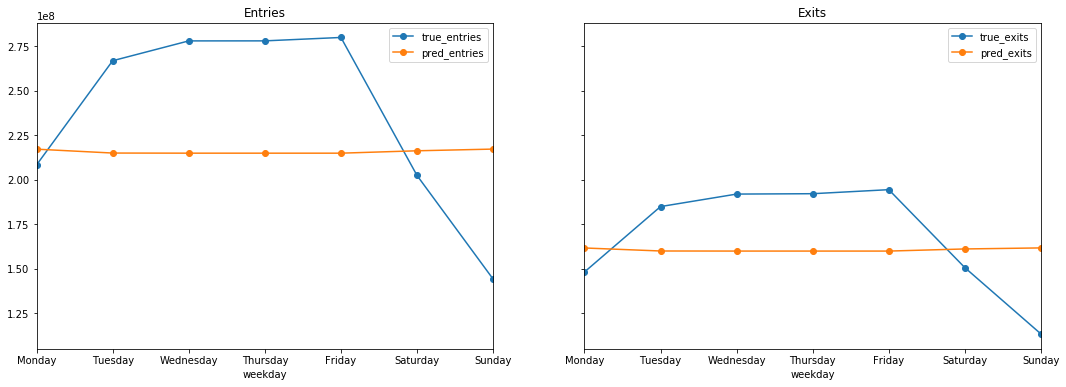

In [51]:
plot_results_time(df_final, group='weekday')

Para as faixas de horários, o modelo teve uma boa previsão, seguindo a tendência real dos dados.

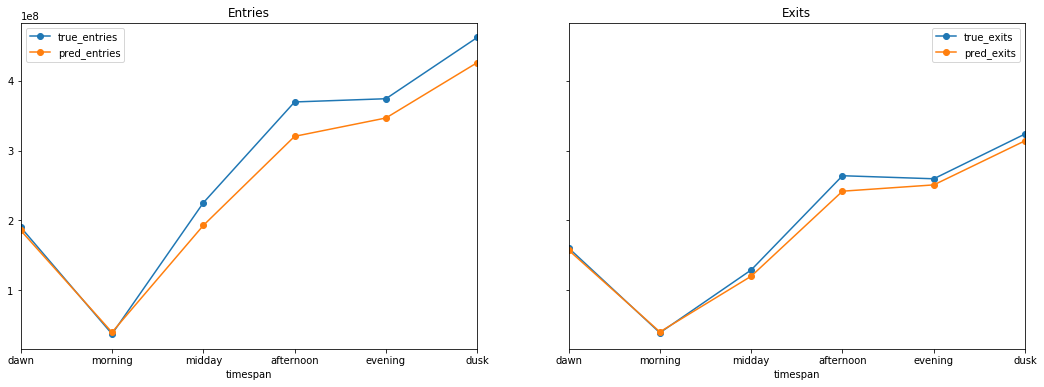

In [52]:
plot_results_time(df_final, group='timespan')

Para plotar o resultado das estações, escolhi 10 estações para entrada que tiveram melhor e pior resultado e outras 10 para saída que obtiveram melhor e pior resultado.

Podemos ver que o modelo praticamente overfittou nesses casos com alta aderência e nos piores casos, o valor predito subestimou a movimentação para maioria das estações.

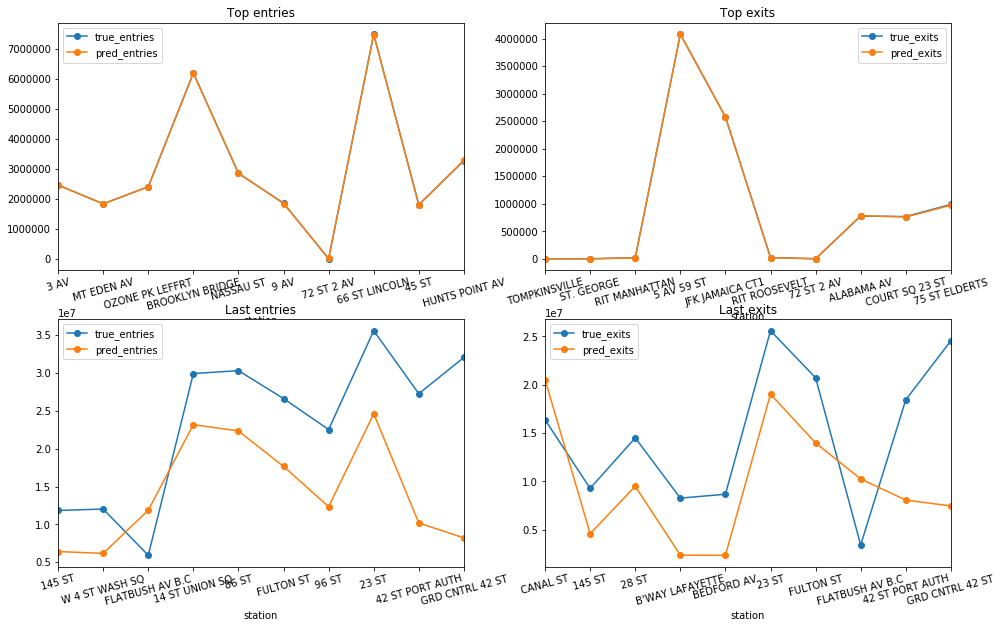

In [53]:
plot_results_location(df_final, 'station')

Já a predição das linhas teve melhor fitting com os valores reais de movimentações.

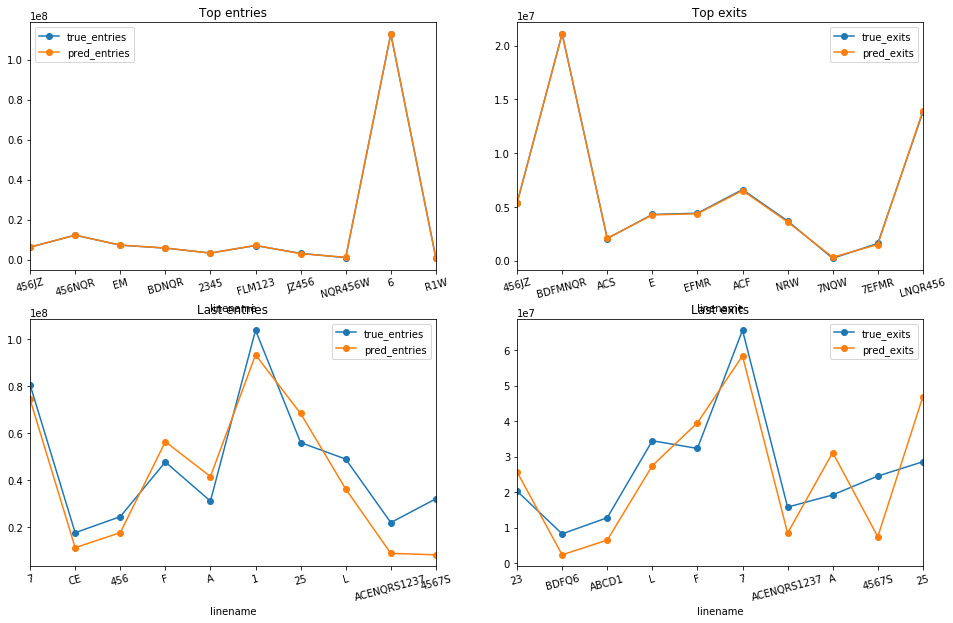

In [54]:
plot_results_location(df_final, 'linename')

## Opinião final
O modelo final obteve um resultado rmsle de `0,954` e `0,989` para prever movimentação de catracas do metrô de Nova York.

Para melhorar o resultado do modelo, poderiam ter sido adicionados bases de feriados locais, datas festivas, variáveis meteorológicas, acidentes de trânsito, dentre outros).

Além disso, poderíamos testar outros modelos de regressão como lightGBM, XGBoost e tunar os parâmetros com hyperopt para chegar à um resultado mais próximo ao real.